Training Neural Network...
Epoch 1/2000
19/19 [==============================] - 1s 11ms/step - loss: 141150.5156 - mean_absolute_error: 141150.5156 - val_loss: 141917.8750 - val_mean_absolute_error: 141917.8750
Epoch 2/2000
19/19 [==============================] - 0s 3ms/step - loss: 140576.9531 - mean_absolute_error: 140576.9531 - val_loss: 140714.4688 - val_mean_absolute_error: 140714.4688
Epoch 3/2000
19/19 [==============================] - 0s 2ms/step - loss: 137987.1562 - mean_absolute_error: 137987.1562 - val_loss: 135917.5000 - val_mean_absolute_error: 135917.5000
Epoch 4/2000
19/19 [==============================] - 0s 2ms/step - loss: 129330.8047 - mean_absolute_error: 129330.8047 - val_loss: 121480.3828 - val_mean_absolute_error: 121480.3828
Epoch 5/2000
19/19 [==============================] - 0s 3ms/step - loss: 105875.3594 - mean_absolute_error: 105875.3594 - val_loss: 86002.1484 - val_mean_absolute_error: 86002.1484
Epoch 6/2000
19/19 [==============================] - 

/home/swiftx/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 20344.90777138158
R² Score: 0.4475869756159814


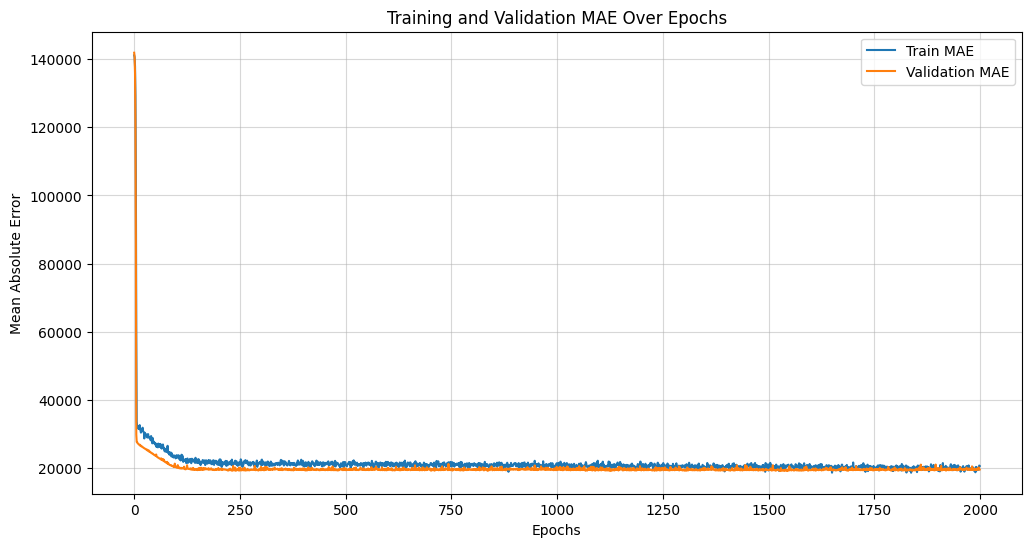

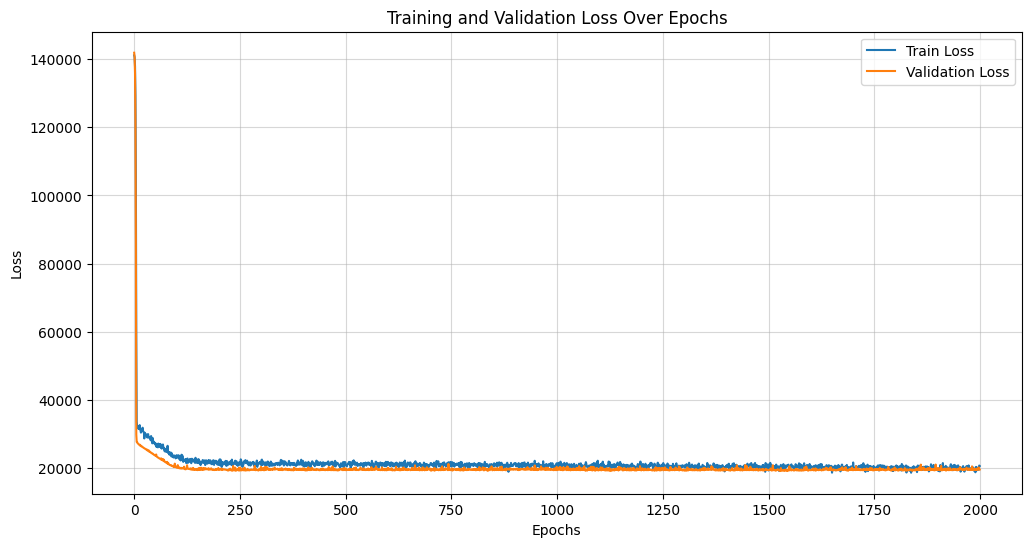

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Load and preprocess the data
file_path = 'modified_data.xlsx'  # Path to the Excel file
data = pd.read_excel(file_path)

# Remove duplicates
data = data.drop_duplicates()

# Filter apartments with specific criteria
data = data[
    (data['Property type_Apartments'] == 1) &  # Only apartments
    (data['Price'] <= 200000) &  # Price <= 250000
    (data['Gross area'] <= 250)  # Area <= 250 m²
]

scaler = MinMaxScaler()
data['Year of construction'] = scaler.fit_transform(data[['Year of construction']])

# Handle missing values
imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Check if there are still any NaN values
if data.isnull().sum().sum() > 0:
    raise ValueError("NaN values remain in the dataset after imputation.")

# Separate target (y) and features (X)
X = data.drop(['Price'], axis=1)  # Exclude the target column
y = data['Price']  # Target variable

# Shuffle the data
data_shuffled = pd.concat([X, y], axis=1)
data_shuffled = shuffle(data_shuffled, random_state=42)

# Split the data into training and testing sets
X = data_shuffled.drop('Price', axis=1)
y = data_shuffled['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a neural network model
def build_neural_network(input_shape):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=input_shape))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    # model.add(Dense(88, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(88, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['mean_absolute_error'])
    return model

# Train the neural network
print("Training Neural Network...")
nn_model = build_neural_network(X_train.shape[1])
history = nn_model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_split=0.2, verbose=1)

# Save the model and preprocessing steps
nn_model.save("Neural_Network_model.h5")
joblib.dump(X.columns.tolist(), "trained_features.pkl")
joblib.dump(imputer, "imputer.pkl")

# Evaluate the neural network
print("\nEvaluating Neural Network...")
y_pred_nn = nn_model.predict(X_test).flatten()
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Mean Absolute Error (MAE): {mae_nn}")
print(f"R² Score: {r2_nn}")

# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Visualize loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.5)
plt.show()


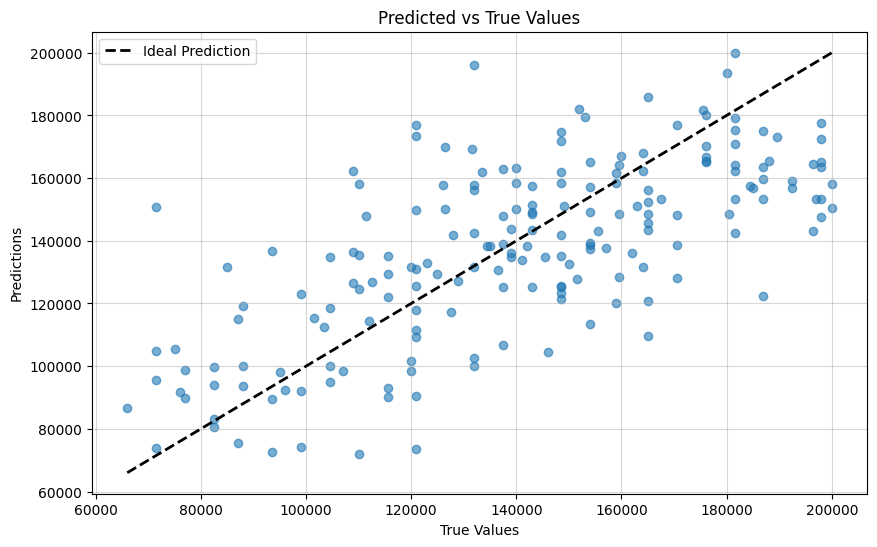

In [71]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Ideal Prediction")
plt.title("Predicted vs True Values")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

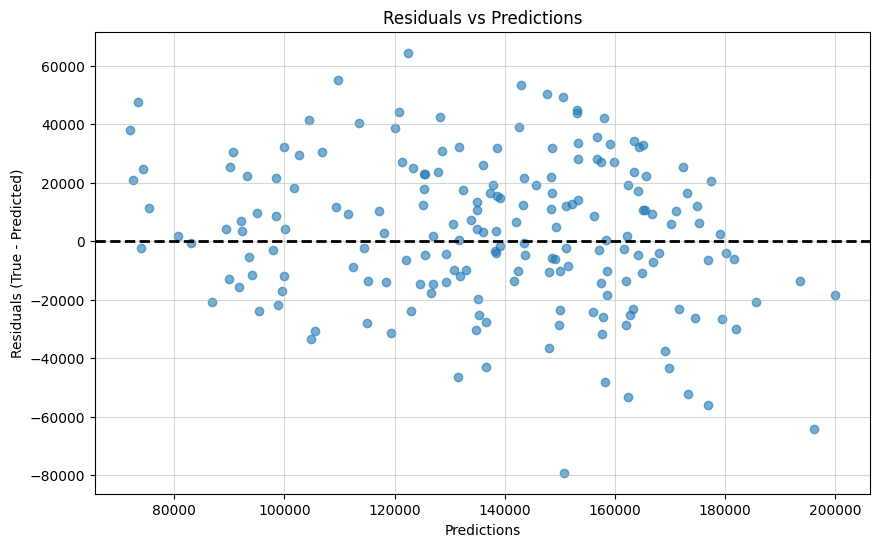

In [72]:
residuals = y_test - y_pred_nn

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_nn, residuals, alpha=0.6)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.title("Residuals vs Predictions")
plt.xlabel("Predictions")
plt.ylabel("Residuals (True - Predicted)")
plt.grid(alpha=0.5)
plt.show()

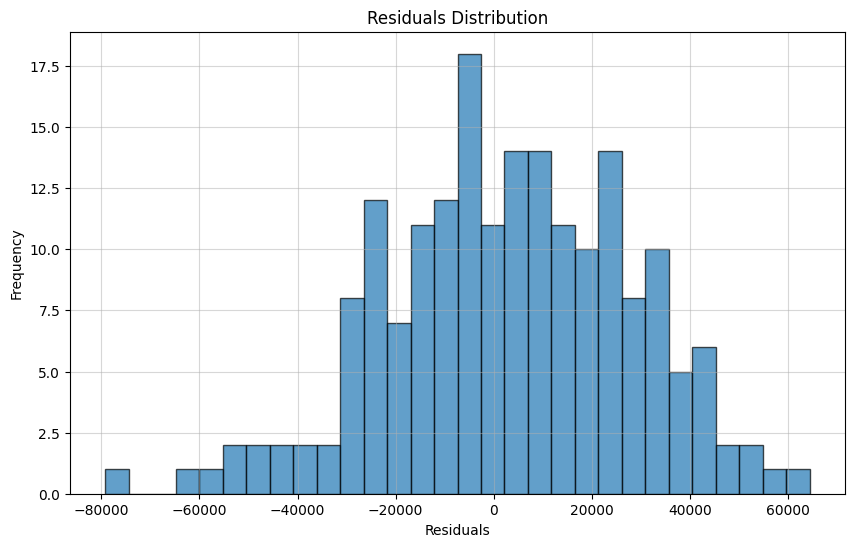

In [73]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(alpha=0.5)
plt.show()

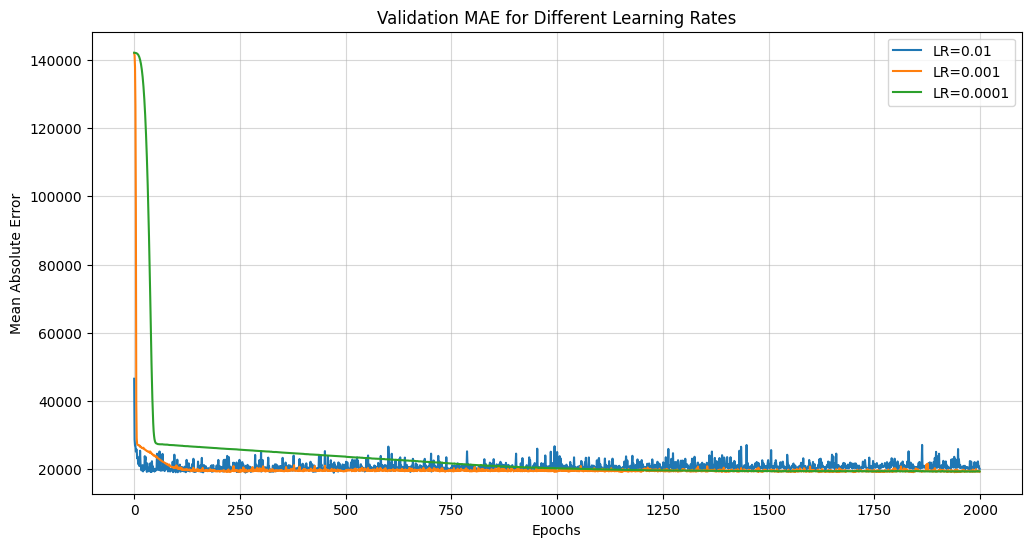

In [75]:
learning_rates = [0.01, 0.001, 0.0001]
histories = []

for lr in learning_rates:
    model = build_neural_network(X_train.shape[1])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_absolute_error', metrics=['mean_absolute_error'])
    history = model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_split=0.2, verbose=0)
    histories.append(history)

# Plot comparison
plt.figure(figsize=(12, 6))
for lr, history in zip(learning_rates, histories):
    plt.plot(history.history['val_mean_absolute_error'], label=f'LR={lr}')
plt.title("Validation MAE for Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(alpha=0.5)
plt.show()


30/30 [==============================] - 0s 688us/step


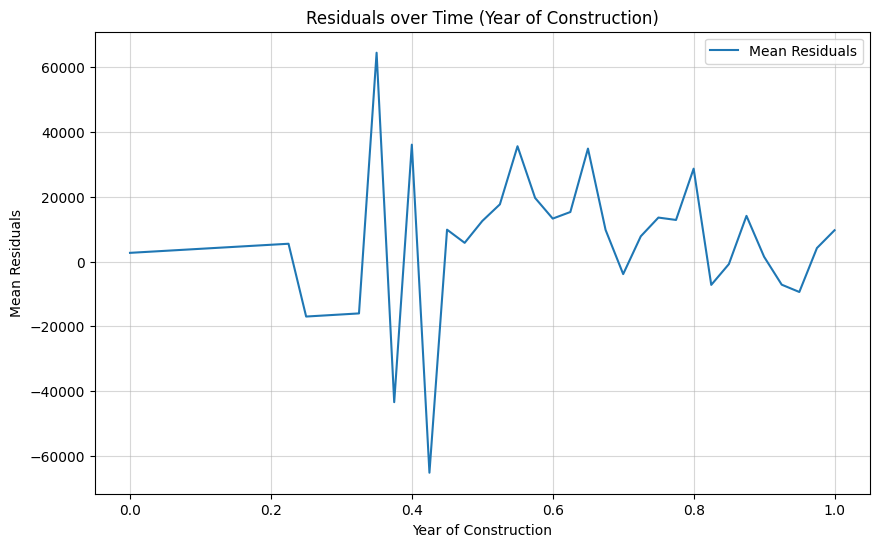

In [77]:
data['Predictions'] = nn_model.predict(X).flatten()
data['Residuals'] = data['Price'] - data['Predictions']

# Group by year
grouped = data.groupby('Year of construction')['Residuals'].mean()

plt.figure(figsize=(10, 6))
plt.plot(grouped.index, grouped.values, label="Mean Residuals")
plt.title("Residuals over Time (Year of Construction)")
plt.xlabel("Year of Construction")
plt.ylabel("Mean Residuals")
plt.grid(alpha=0.5)
plt.legend()
plt.show()

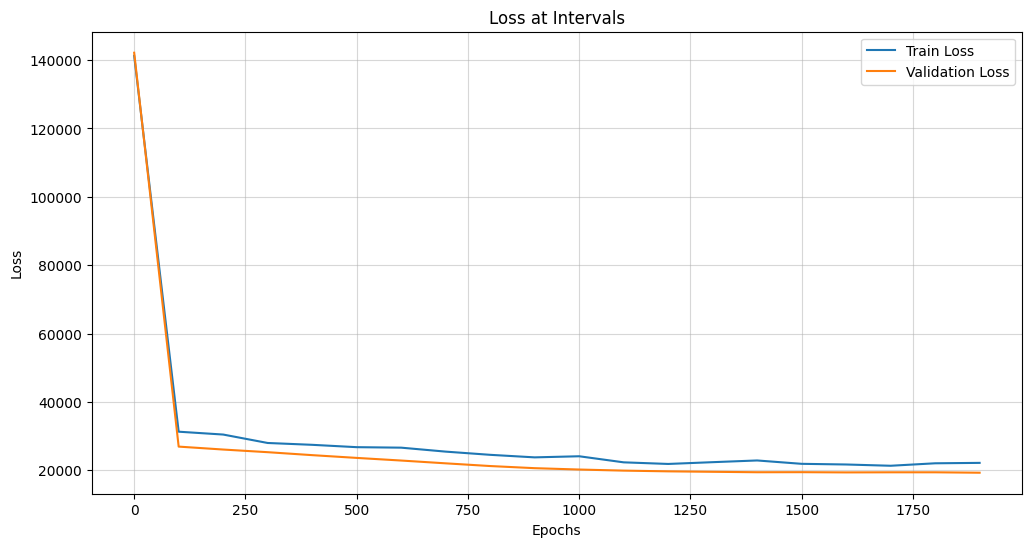

In [78]:
epochs = range(0, len(history.history['loss']), 100)
plt.figure(figsize=(12, 6))
plt.plot(epochs, [history.history['loss'][e] for e in epochs], label='Train Loss')
plt.plot(epochs, [history.history['val_loss'][e] for e in epochs], label='Validation Loss')
plt.title("Loss at Intervals")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.5)
plt.show()